In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import seaborn as sns

## Analyzing the Impact of Female Directors and Writers

To answer what impact female directors and writers have we will take our director data from WikiData and supplemented CMU movie data to see underlying trends that may be present as well as understanding the impact of female writers and directors on a movie's IMDB rating.

### Contents
- [Merging and Cleaning](#merging_and_cleaning)
- [Analysis](#analysis)
    - [General Analysis](#general-analysis)
    - [Overall Difference Between Genders](#gender-diff)
    - [Director and Writer Breakdown per Movie](#director-writer-break)
    - [Genre Analysis](#genre)
    - [Directors and Writers in the Top 1000 Movies](#top-100)



### Merging and Cleaning <a id='Merging_and_cleaning'></a>
First we will merge our two relevent datasets together.

In [2]:
movies_full = pd.read_pickle('./data/pickles/movies.p')
directors_full = pd.read_pickle('./data/pickles/director_writer_nodrop.p')

print(movies_full.columns)
print(directors_full.columns)

Index(['title', 'primaryTitle', 'originalTitle', 'wikipedia_id',
       'freebase_id_cmu', 'wikidata_id', 'IMDB_id', 'mojo_id',
       'release_year_cmu', 'release_year_wd', 'release_year_imdb',
       'combined_release_year', 'runtime_cmu', 'runtime_wd', 'runtime_imdb',
       'combined_runtime', 'box_office_cmu', 'box_office_wd',
       'box_office_mojo', 'combined_box_office', 'languages', 'countries',
       'averageRating_imdb', 'numVotes_imdb', 'genres_cmu', 'genres_imdb',
       'directors', 'writers', 'metric'],
      dtype='object')
Index(['title', 'movie_wiki_id', 'movie_wikidata_id', 'movie_freebase_id',
       'movie_imdb_id', 'role', 'imdb_id', 'wikidata_id', 'name', 'gender',
       'birth', 'height'],
      dtype='object')


There are many columns that are not relevant to the analysis to be done and therefore we will create a new DataFrame for both the movies and directors that have the columns to be analyzed.

In [3]:
movies = movies_full[[
    'title',
    'freebase_id_cmu',
    'combined_release_year',
    'combined_runtime',
    'averageRating_imdb',
    'numVotes_imdb',
    'genres_cmu',
    'genres_imdb'
]].copy()

print(f'The length of the dataset is {len(movies)}, the number of freebase IDs is {len(movies.freebase_id_cmu.notna())}')
movies.genres_cmu = movies.genres_cmu.apply(lambda x: eval(x))
movies.head()

The length of the dataset is 81741, the number of freebase IDs is 81741


,title,freebase_id_cmu,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,genres_imdb
0,Ghosts of Mars,/m/03vyhn,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","Action,Horror,Sci-Fi"
1,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",Drama
2,Brun bitter,/m/0crgdbh,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","Crime,Drama"
3,White Of The Eye,/m/0285_cd,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","Horror,Thriller"
4,A Woman in Flames,/m/01mrr1,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},Drama


In [4]:
directors = directors_full[[
    'title',
    'movie_freebase_id',
    'movie_imdb_id',
    'role',
    'name',
    'imdb_id',
    'wikidata_id',
    'gender',
    'birth',
    'height',
]]
directors.head()

,title,movie_freebase_id,movie_imdb_id,role,name,imdb_id,wikidata_id,gender,birth,height
0,Ghosts of Mars,/m/03vyhn,tt0228333,director,John Carpenter,nm0000118,Q95008,male,1948-01-16,NaN
1,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,tt0245916,director,NaN,nm1740285,NaN,NaN,NaN,NaN
2,Brun bitter,/m/0crgdbh,tt0094806,director,Sølve Skagen,nm0803751,Q7666470,male,1945-02-17,NaN
3,White Of The Eye,/m/0285_cd,tt0094320,director,Donald Cammell,nm0131910,Q975488,male,1934-01-17,NaN
4,A Woman in Flames,/m/01mrr1,tt0083949,director,Robert van Ackeren,nm0885554,Q88104,male,1946-12-22,NaN


The data will be merged on the movie freebase ID

In [5]:
directors_movies_merge = pd.merge(left=directors, right=movies, how='left', 
                                    left_on='movie_freebase_id', right_on='freebase_id_cmu')

directors_movies_merge.head()

,title_x,movie_freebase_id,movie_imdb_id,role,name,imdb_id,wikidata_id,gender,birth,height,title_y,freebase_id_cmu,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,genres_imdb
0,Ghosts of Mars,/m/03vyhn,tt0228333,director,John Carpenter,nm0000118,Q95008,male,1948-01-16,NaN,Ghosts of Mars,/m/03vyhn,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","Action,Horror,Sci-Fi"
1,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,tt0245916,director,NaN,nm1740285,NaN,NaN,NaN,NaN,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",Drama
2,Brun bitter,/m/0crgdbh,tt0094806,director,Sølve Skagen,nm0803751,Q7666470,male,1945-02-17,NaN,Brun bitter,/m/0crgdbh,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","Crime,Drama"
3,White Of The Eye,/m/0285_cd,tt0094320,director,Donald Cammell,nm0131910,Q975488,male,1934-01-17,NaN,White Of The Eye,/m/0285_cd,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","Horror,Thriller"
4,A Woman in Flames,/m/01mrr1,tt0083949,director,Robert van Ackeren,nm0885554,Q88104,male,1946-12-22,NaN,A Woman in Flames,/m/01mrr1,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},Drama


After merging the dataset will need some cleaning before it can be analyzed.

In [6]:
print(all(directors_movies_merge.title_x == directors_movies_merge.title_y)) #are title_x and title_y are exactly the same?
directors_movies = directors_movies_merge[[
    'title_x',
    'combined_release_year',
    'combined_runtime',
    'averageRating_imdb',
    'numVotes_imdb',
    'genres_cmu',
    'genres_imdb',
    'movie_freebase_id',
    'movie_imdb_id',
    'imdb_id',
    'role',
    'name',
    'gender',
    'birth',
    'height',
]].copy()

directors_movies.head()

True


,title_x,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,genres_imdb,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","Action,Horror,Sci-Fi",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",Drama,/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","Crime,Drama",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","Horror,Thriller",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},Drama,/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN


The birth dates are stored as strings. For our analysis we will be using the birth year to obtain an "age at movie release" column so that we can also see how the success of directors and writers may change over their career.

In [7]:
directors_movies['birth_year'] = directors_movies.birth.apply(lambda x: int(x.split('-')[0]) if isinstance(x,str) else x)
directors_movies.head()

,title_x,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,genres_imdb,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,birth_year
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","Action,Horror,Sci-Fi",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,1948.0
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",Drama,/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","Crime,Drama",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,1945.0
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","Horror,Thriller",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,1934.0
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},Drama,/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,1946.0


In [8]:
print(f'There are {len(directors_movies[directors_movies.combined_release_year.isna()])} NaN values in the combined release year column')
print(f'There are {len(directors_movies[directors_movies.birth_year.isna()])} NaN values in the birth year column')

There are 2 NaN values in the combined release year column
There are 91335 NaN values in the birth year column


In [9]:
#create a column to store age at release values
directors_movies['age_at_release'] = np.nan

#fill in with actual values of age at release year if there is both a release year and a birth year
for indx, row in directors_movies.loc[directors_movies.combined_release_year.notna() & directors_movies.birth_year.notna()].iterrows():
    directors_movies.loc[indx,'age_at_release'] = row.combined_release_year- row.birth_year

directors_movies.head()

,title_x,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,genres_imdb,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,birth_year,age_at_release
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","Action,Horror,Sci-Fi",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,1948.0,53.0
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",Drama,/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","Crime,Drama",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,1945.0,43.0
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","Horror,Thriller",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,1934.0,53.0
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},Drama,/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,1946.0,37.0


Previously the CMU movie genres were used, but now the IMDB movie genres will be used and the code associated with the CMU genres will be commented out

The genre data is currently stored as a dictionary with the the freebase ID as the key and the genre as the value. Let's change this to just a list of genres per movie. 

In [10]:
# From previous Analysis 

# print(f'There are {len(directors_movies[directors_movies.genres_cmu.isna()])} NaN values in the genres_cmu column')
# directors_movies.genres_cmu = directors_movies.genres_cmu.apply(lambda x: list(x.values()))

In [11]:
print(f'There are {len(directors_movies[directors_movies.genres_imdb.isna()])} NaN values in the genres_imdb column')
# directors_movies.dropna(axis=1, subset='genres_imdb', inplace=True)
# print(f'There are now {len(directors_movies[directors_movies.genres_imdb.isna()])} NaN values in the genres_imdb column')
directors_movies.genres_imdb = directors_movies.genres_imdb.apply(lambda x: str(x).split(','))

There are 6 NaN values in the genres_imdb column


Lastly for the ease of analysis some of the column names will be changed/shortened.

In [12]:
directors_movies.rename(mapper={
    'title_x': 'title',
    'combined_runtime':'runtime',
    'combined_release_year':'release_year',
    'averageRating_imdb':'rating',
    'genres_imdb':'genres',
    'numVotes_imdb':'num_votes'    
},inplace=True, axis=1)
directors_movies.head()

,title,release_year,runtime,rating,num_votes,genres_cmu,genres,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,birth_year,age_at_release
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[Action, Horror, Sci-Fi]",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,1948.0,53.0
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",[Drama],/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","[Crime, Drama]",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,1945.0,43.0
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","[Horror, Thriller]",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,1934.0,53.0
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},[Drama],/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,1946.0,37.0


In [13]:
directors_movies.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,250743.000000,238079.000000,234845.000000,2.348450e+05,159410.000000,159409.000000
mean,1975.509402,94.538418,6.300630,1.263893e+04,1928.547337,44.177951
std,28.481179,90.933387,1.149018,6.790405e+04,30.173960,15.259160
min,1878.000000,0.000000,1.000000,5.000000e+00,1.000000,-48.000000
25%,1953.000000,80.000000,5.700000,1.360000e+02,1904.000000,36.000000
50%,1981.000000,93.000000,6.400000,5.870000e+02,1928.000000,42.000000
75%,2002.000000,107.000000,7.100000,2.745000e+03,1953.000000,51.000000
max,2023.000000,14400.000000,10.000000,2.648879e+06,2005.000000,1999.000000


Looks like we need to do a little bit of cleaning on the age_at_release column. The assumption is being made that children are not able to work as directors or writers and we will remove age at release values that are less than 18 and the oldest acting film director was Manoel de Oliveira who worked until he was approximately 99. In general we can assume that values this high could be outliers

In [14]:
directors_movies.age_at_release=directors_movies.age_at_release.apply(lambda x: np.nan if x<18 else (np.nan if x> 99 else x))
directors_movies.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,250743.000000,238079.000000,234845.000000,2.348450e+05,159410.000000,156027.000000
mean,1975.509402,94.538418,6.300630,1.263893e+04,1928.547337,43.988105
std,28.481179,90.933387,1.149018,6.790405e+04,30.173960,11.662638
min,1878.000000,0.000000,1.000000,5.000000e+00,1.000000,18.000000
25%,1953.000000,80.000000,5.700000,1.360000e+02,1904.000000,36.000000
50%,1981.000000,93.000000,6.400000,5.870000e+02,1928.000000,42.000000
75%,2002.000000,107.000000,7.100000,2.745000e+03,1953.000000,50.000000
max,2023.000000,14400.000000,10.000000,2.648879e+06,2005.000000,99.000000


Now that we have a new metric we can add that in here so that it can propagate throughout the rest of the DataFrames referenced later on in the notebook

In [15]:
mean_ratings = directors_movies.rating.mean()
std_ratings = directors_movies.rating.std()
directors_movies['normal_rating'] = (directors_movies.rating-mean_ratings)/std_ratings
directors_movies['abs_normal_rating'] = abs(directors_movies.normal_rating)

directors_movies['log_num_votes'] = np.log(directors_movies.num_votes)
mean_log_votes = directors_movies.log_num_votes.mean()
std_log_votes = directors_movies.log_num_votes.std()
directors_movies['normal_log_num_votes'] = (directors_movies.log_num_votes - mean_log_votes)/std_log_votes
min_norm_log_num_votes = directors_movies.normal_log_num_votes.min()

directors_movies['impact_score'] = (directors_movies.normal_log_num_votes) * directors_movies.abs_normal_rating
directors_movies.drop(['normal_rating', 'abs_normal_rating', 'log_num_votes', 'normal_log_num_votes'],axis=1, inplace=True )

directors_movies.head()

,title,release_year,runtime,rating,num_votes,genres_cmu,genres,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,birth_year,age_at_release,impact_score
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[Action, Horror, Sci-Fi]",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,1948.0,53.0,2.350853
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",[Drama],/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN,NaN,-0.357369
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","[Crime, Drama]",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,1945.0,43.0,-0.650711
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","[Horror, Thriller]",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,1934.0,53.0,0.100801
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},[Drama],/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,1946.0,37.0,-0.017109


Now to fix the genres, first the cmu movie genres will be dropped and then the IMDB genres will be changed into different columns, first to confirm the max amount of IMDB genres that a movie has. From our previous data exploration there should only be three.

In [16]:
number_of_genres = directors_movies.genres.apply(lambda x: len(x))
number_of_genres.max()

3

Now that the max number of genres has been established the genres can be split into three separate dataframe columns

In [17]:
directors_movies['genre_1'] =  directors_movies.genres.apply(lambda x: x[0] if len(x)>0 else np.nan)
directors_movies['genre_2'] =  directors_movies.genres.apply(lambda x: x[1] if len(x)>1 else np.nan)
directors_movies['genre_3'] =  directors_movies.genres.apply(lambda x: x[2] if len(x)>2 else np.nan)
directors_movies.head()

,title,release_year,runtime,rating,num_votes,genres_cmu,genres,movie_freebase_id,movie_imdb_id,imdb_id,...,name,gender,birth,height,birth_year,age_at_release,impact_score,genre_1,genre_2,genre_3
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[Action, Horror, Sci-Fi]",/m/03vyhn,tt0228333,nm0000118,...,John Carpenter,male,1948-01-16,NaN,1948.0,53.0,2.350853,Action,Horror,Sci-Fi
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",[Drama],/m/08yl5d,tt0245916,nm1740285,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.357369,Drama,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","[Crime, Drama]",/m/0crgdbh,tt0094806,nm0803751,...,Sølve Skagen,male,1945-02-17,NaN,1945.0,43.0,-0.650711,Crime,Drama,NaN
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","[Horror, Thriller]",/m/0285_cd,tt0094320,nm0131910,...,Donald Cammell,male,1934-01-17,NaN,1934.0,53.0,0.100801,Horror,Thriller,NaN
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},[Drama],/m/01mrr1,tt0083949,nm0885554,...,Robert van Ackeren,male,1946-12-22,NaN,1946.0,37.0,-0.017109,Drama,NaN,NaN


### Analysis <a id='analysis'></a>


#### General Analysis <a id='general_analysis'></a>

Before getting too deep into the analysis it should be understood what is in the data and what is missing from the data.

 We can first understand what director data was able to be collected. how many movies have complete director and writer data, how many movies have at least one director or writer present and how many directors and writers are present for each gender.

In [18]:
dirs = directors_movies[directors_movies.role == 'director']
writers = directors_movies[directors_movies.role == 'writer']
dir_num_tot = dirs.imdb_id.nunique()
wri_num_tot = writers.imdb_id.nunique()
uniq_dirs = dirs.drop_duplicates(subset='imdb_id', keep='first')
uniq_wris = writers.drop_duplicates(subset='imdb_id', keep='first')
full_dirs = uniq_dirs.dropna(subset=['gender', 'name', 'birth'])
full_wris = uniq_wris.dropna(subset=['gender', 'name', 'birth'])

print(f'Out of {len(directors_movies)} rows of data:')
print(f'There are {len(dirs)} number of directors and {len(writers)} number of writers.')
print(f'There are {dir_num_tot} number of unique directors and {wri_num_tot} number of unique writers.')
print(f'\nOut of all of the unique directors {len(uniq_dirs[uniq_dirs.name.notna()])} have a name, {len(uniq_dirs[uniq_dirs.gender.notna()])} have a gender, {len(uniq_dirs[uniq_dirs.height.notna()])} have a height, and {len(uniq_dirs[uniq_dirs.birth_year.notna()])} have a birth year.')
print(f'\nOut of all of the unique writers {len(uniq_wris[uniq_wris.name.notna()])} have a name, {len(uniq_wris[uniq_wris.gender.notna()])} have a gender, {len(uniq_wris[uniq_wris.height.notna()])} have a height, and {len(uniq_wris[uniq_wris.birth_year.notna()])} have a birth year.')
print(f'\nFor this analysis height and ethinicity will not be considered due to lack of complete data')
print(f'Out of all of the directors there are {len(full_dirs)} with complete gender, name, and birth data')
print(f'Out of all of the writers there are {len(full_wris)} with complete gender, name, and birth data')

Out of 250745 rows of data:
There are 86474 number of directors and 164271 number of writers.
There are 29028 number of unique directors and 60785 number of unique writers.

Out of all of the unique directors 21392 have a name, 18931 have a gender, 131 have a height, and 16952 have a birth year.

Out of all of the unique writers 26413 have a name, 24741 have a gender, 176 have a height, and 22489 have a birth year.

For this analysis height and ethinicity will not be considered due to lack of complete data
Out of all of the directors there are 16823 with complete gender, name, and birth data
Out of all of the writers there are 22399 with complete gender, name, and birth data


Let's see how many movies are present that have a complete set of directors and writers that have at least gender information

In [19]:
movie_groups = directors_movies.groupby('movie_freebase_id')

for fb_id, movie in tqdm(movie_groups):
    all_data = True
    indices = []
    for indx, row in movie.iterrows():
        indices.append(indx)
        if row.gender != 'male' and row.gender!= 'female':
            all_data = False
    directors_movies.loc[indices,'all_crew'] = all_data
    

100%|██████████| 74200/74200 [00:46<00:00, 1612.94it/s]


In [20]:
full_crew = directors_movies[directors_movies.all_crew == True]
print(f'Out of {directors_movies.movie_freebase_id.nunique()}, there are {directors_movies[directors_movies.gender.notna()].movie_freebase_id.nunique()} movies that have at least one director or writer with gender data')
print(f'and there are {full_crew.movie_freebase_id.nunique()} movies with full crew gender data.')
print(f'This is means that {round(directors_movies[directors_movies.gender.notna()].movie_freebase_id.nunique()/directors_movies.movie_freebase_id.nunique(),4)*100}% have at least one point of gender data and {100*round(full_crew.movie_freebase_id.nunique()/directors_movies.movie_freebase_id.nunique(),4)}% of the movies have full crew gender data.')

Out of 74200, there are 67022 movies that have at least one director or writer with gender data
and there are 28344 movies with full crew gender data.
This is means that 90.33% have at least one point of gender data and 38.2% of the movies have full crew gender data.


It would also be interesting to see how many people there is at least gender data for that have worked as both directors and writers.

In [21]:
both_dir_writer = directors_movies.dropna(subset='gender').groupby('imdb_id').role.nunique()
print(f'There are {len(both_dir_writer[both_dir_writer>1])} number of people who have gender data that have worked as both a director and writer.')

There are 12812 number of people who have gender data that have worked as both a director and writer.


From the above analysis we can see that in general there is a lot of data available for analysis on gender and still a significant portion of data available with gender data on the full crew. There is also more complete data on a larger percentage of the directors than for the writers and there are many people who work as both a writer and a director.

Now that we have an understanding of the number of data points that are present. the data can start to be analyzed for trends. To start the data set can be split into male writers/directors and female writers/directors and analyzed.



#### Overall Differnce Between Genders <a id='gender-diff'></a>

The data can be divided by role and gender to start an exploratory analysis into what trends may exist within the data.

In [22]:
male_dir = directors_movies.loc[(directors_movies.gender == 'male') & (directors_movies.role == 'director')]
male_writer = directors_movies.loc[(directors_movies.gender == 'male') & (directors_movies.role == 'writer')]
female_dir = directors_movies.loc[(directors_movies.gender == 'female') & (directors_movies.role == 'director')]
female_writer = directors_movies.loc[(directors_movies.gender == 'female') & (directors_movies.role == 'writer')]

male_dir.describe()


,release_year,runtime,rating,num_votes,birth_year,age_at_release,impact_score
count,67324.000000,63788.000000,62598.000000,6.259800e+04,63935.000000,62835.000000,62598.000000
mean,1973.883533,93.113125,6.320830,1.263103e+04,1928.987597,43.869038,0.030602
std,28.971427,69.181688,1.119809,6.753251e+04,30.574989,10.824169,1.009654
min,1878.000000,0.000000,1.000000,5.000000e+00,1.000000,18.000000,-8.357554
25%,1951.000000,78.000000,5.700000,1.380000e+02,1904.000000,36.000000,-0.331794
50%,1979.000000,93.000000,6.400000,5.940000e+02,1930.000000,43.000000,-0.004060
75%,2001.000000,107.000000,7.100000,2.790000e+03,1954.000000,50.000000,0.328509
max,2023.000000,9360.000000,9.700000,2.648879e+06,2005.000000,99.000000,9.473819


In [23]:
female_dir.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release,impact_score
count,3684.000000,3530.000000,3574.000000,3574.000000,3303.000000,3135.000000,3574.000000
mean,1995.234256,91.100567,6.521461,8040.533016,1952.075992,42.946093,-0.007187
std,18.223824,36.059259,1.060528,36770.891430,23.090885,11.042355,0.913193
min,1896.000000,1.000000,1.600000,5.000000,1872.000000,18.000000,-7.582732
25%,1990.000000,81.000000,5.900000,155.000000,1945.000000,35.000000,-0.338776
50%,2001.000000,93.000000,6.600000,595.000000,1956.000000,42.000000,-0.015622
75%,2007.000000,105.000000,7.200000,2676.500000,1967.000000,50.000000,0.275907
max,2019.000000,763.000000,9.400000,842297.000000,2000.000000,99.000000,6.156391


In [24]:
male_writer.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release,impact_score
count,87412.000000,85009.000000,83345.000000,8.334500e+04,83061.000000,81239.000000,83345.000000
mean,1972.902153,95.785964,6.344337,1.790191e+04,1927.126208,44.206256,0.147137
std,27.588140,46.702281,1.067692,8.334330e+04,29.477983,12.217594,1.015665
min,1894.000000,0.000000,1.000000,5.000000e+00,1622.000000,18.000000,-8.357554
25%,1950.000000,82.000000,5.800000,1.760000e+02,1904.000000,36.000000,-0.239697
50%,1975.000000,94.000000,6.500000,7.770000e+02,1926.000000,42.000000,0.004318
75%,1999.000000,108.000000,7.100000,3.900000e+03,1952.000000,51.000000,0.425800
max,2023.000000,4875.000000,9.500000,2.648879e+06,2005.000000,99.000000,9.473819


In [25]:
female_writer.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release,impact_score
count,9466.000000,9266.000000,8964.000000,8.964000e+03,8661.000000,8372.000000,8964.000000
mean,1975.081449,93.585474,6.385118,1.481325e+04,1929.351230,43.327401,0.148504
std,30.935200,33.906616,0.980755,7.756710e+04,32.321029,12.436923,0.947292
min,1896.000000,1.000000,1.000000,5.000000e+00,1850.000000,18.000000,-8.181308
25%,1945.000000,80.000000,5.900000,2.190000e+02,1899.000000,35.000000,-0.184992
50%,1986.000000,93.000000,6.500000,8.210000e+02,1932.000000,41.000000,0.009823
75%,2004.000000,106.000000,7.000000,3.840500e+03,1958.000000,50.000000,0.379550
max,2022.000000,822.000000,9.400000,1.851387e+06,2000.000000,99.000000,8.141760


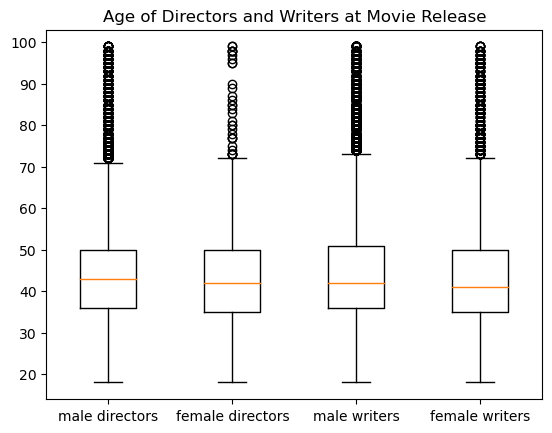

In [26]:

plt.boxplot([male_dir.age_at_release.dropna(), 
    female_dir.age_at_release.dropna(), 
    male_writer.age_at_release.dropna(), 
    female_writer.age_at_release.dropna()],
    showfliers=None,
    labels=['male directors', 'female directors', 'male writers', 'female writers']
)
plt.title('Age of Directors and Writers at Movie Release')
None


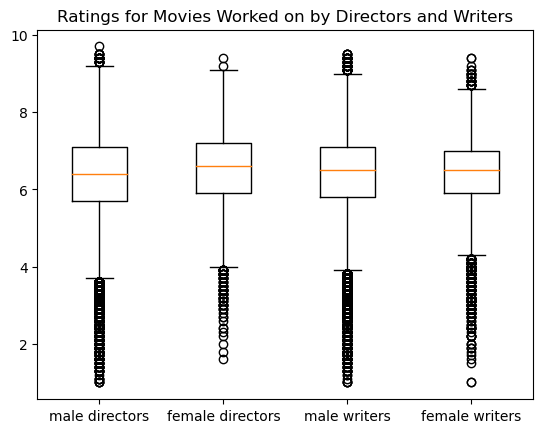

In [27]:
plt.boxplot([male_dir.rating.dropna(), 
    female_dir.rating.dropna(), 
    male_writer.rating.dropna(), 
    female_writer.rating.dropna()],
    showfliers=None,
    labels=['male directors', 'female directors', 'male writers', 'female writers']
)
plt.title('Ratings for Movies Worked on by Directors and Writers')
None

Outliers were taken out for this analysis because they do not allow for the box plots to be visible


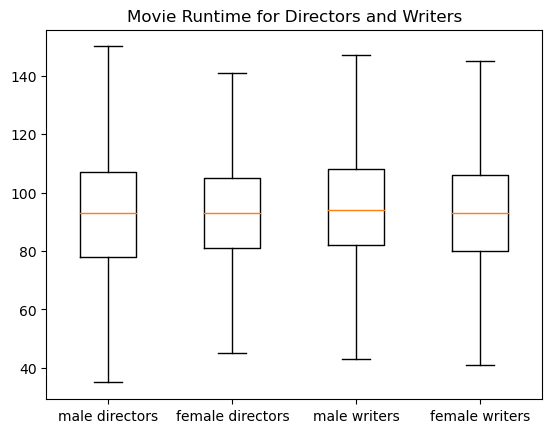

In [28]:
plt.boxplot([male_dir.runtime.dropna(), 
    female_dir.runtime.dropna(), 
    male_writer.runtime.dropna(), 
    female_writer.runtime.dropna()],
    showfliers=False,
    labels=['male directors', 'female directors', 'male writers', 'female writers']
)
plt.title('Movie Runtime for Directors and Writers')
print('Outliers were taken out for this analysis because they do not allow for the box plots to be visible')

In [29]:
print('there were a lot of outliers here so the data was presented as text instead of plots.')
print(f'The median number of votes for male directors is {male_dir.num_votes.median()}, the mean is {male_dir.num_votes.mean()}, and the standard deviation is {male_dir.num_votes.std()}\n')
print(f'The median number of votes for female directors is {female_dir.num_votes.median()}, the mean is {female_dir.num_votes.mean()}, and the standard deviation is {female_dir.num_votes.std()}\n')
print(f'The median number of votes for male writers is {male_writer.num_votes.median()}, the mean is {male_writer.num_votes.mean()}, and the standard deviation is {male_writer.num_votes.std()}\n')
print(f'The median number of votes for female writers is {female_writer.num_votes.median()}, the mean is {female_writer.num_votes.mean()}, and the standard deviation is {female_writer.num_votes.std()}\n')

there were a lot of outliers here so the data was presented as text instead of plots.
The median number of votes for male directors is 594.0, the mean is 12631.025384197577, and the standard deviation is 67532.51112488486

The median number of votes for female directors is 595.0, the mean is 8040.533016228315, and the standard deviation is 36770.89142988577

The median number of votes for male writers is 777.0, the mean is 17901.907360969464, and the standard deviation is 83343.296332814

The median number of votes for female writers is 821.0, the mean is 14813.24788041053, and the standard deviation is 77567.10141774891



From the above plot it can be seen that in general the age range for directors and writers at movie release, movie ratings, and movie runtime is consistent between men and women. The data for number of votes contains large descrepancies and is dificult to analyze on the service, but it can be seen that the standard deviation for each group is very large compared to the mean and median.

Text(37.597222222222214, 0.5, 'male director age')

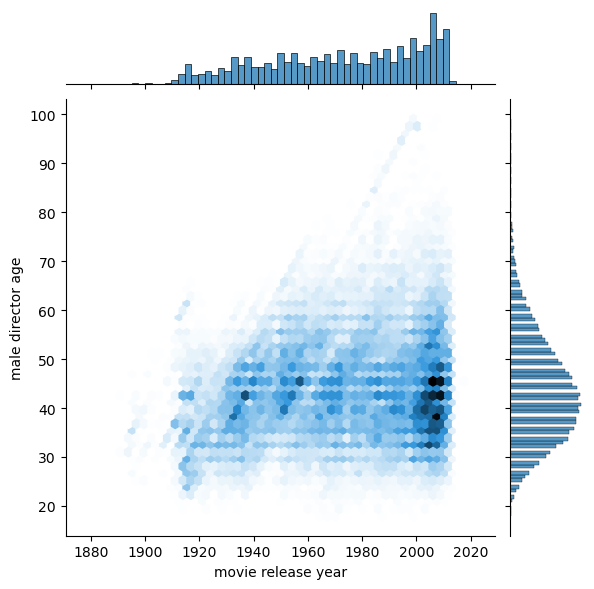

In [30]:
sns.jointplot(x='release_year', y='age_at_release', data=male_dir, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('male director age')

Text(37.597222222222214, 0.5, 'female director age')

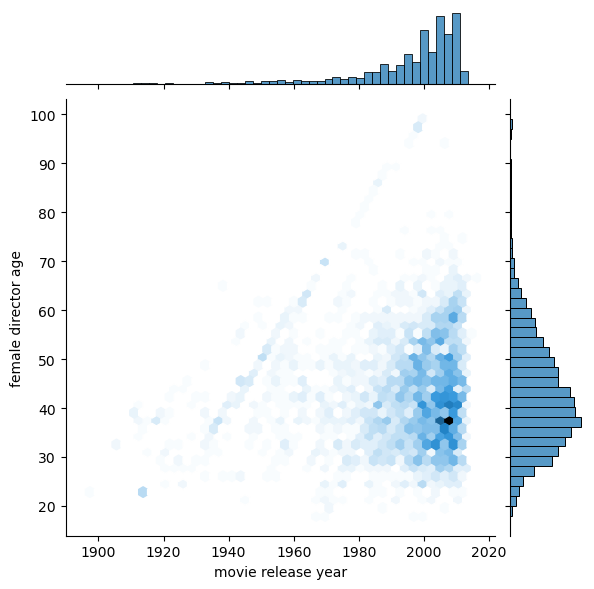

In [31]:
sns.jointplot(x='release_year', y='age_at_release', data=female_dir, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('female director age')

Text(37.597222222222214, 0.5, 'male writer age')

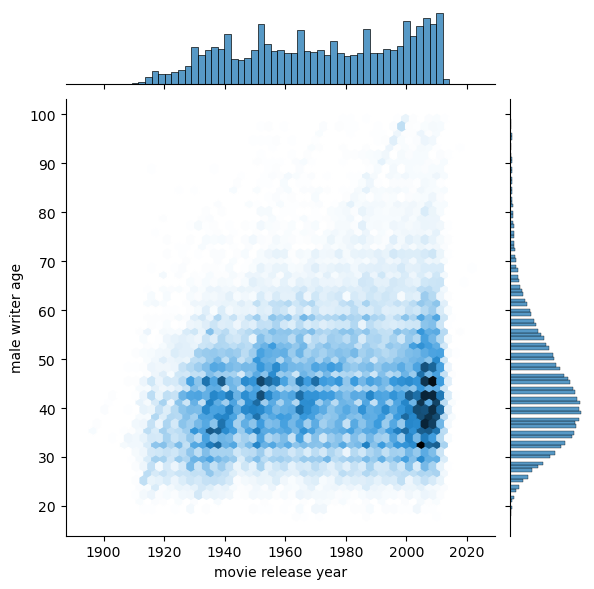

In [32]:
sns.jointplot(x='release_year', y='age_at_release', data=male_writer, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('male writer age')

Text(37.597222222222214, 0.5, 'female writer age')

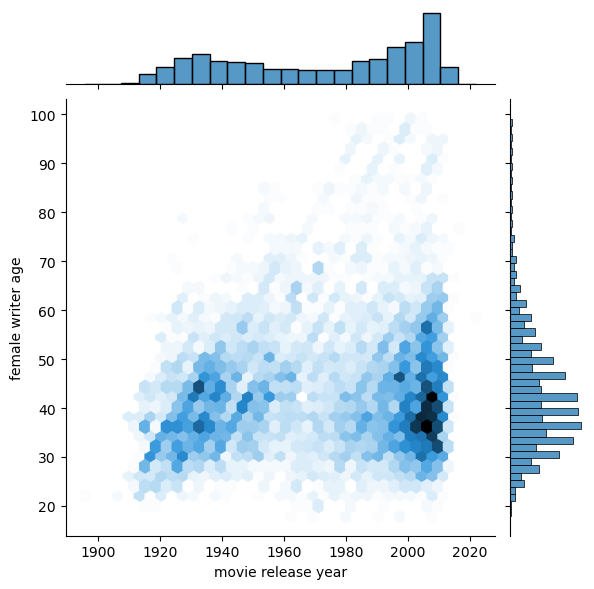

In [33]:
sns.jointplot(x='release_year', y='age_at_release', data=female_writer, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('female writer age')

From the above graphs we can see that in general the age of  male writers and directors has been fairly consistent throughout the time period in the CMU dataset, but it can be seen that there is a large increase in the amount of female directors past 1980 and a bimodal distribution of female writers.

Next the number of directors and writers will be analyzed.

Text(0.5, 0, 'female writers')

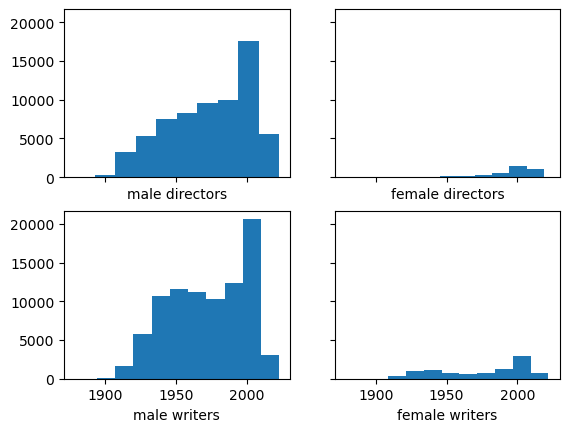

In [34]:
fig, ax = plt.subplots(2,2, sharex= True, sharey= True)
ax[0,0].hist(male_dir.release_year)
ax[0,1].hist(female_dir.release_year)
ax[1,0].hist(male_writer.release_year)
ax[1,1].hist(female_writer.release_year)
ax[0,0].set_xlabel('male directors')
ax[0,1].set_xlabel('female directors')
ax[1,0].set_xlabel('male writers')
ax[1,1].set_xlabel('female writers')


From the above histrograms it can be seen that the number of female directors and writers that took part in movies compared to male directors and writers.

Text(0.5, 0, 'movie release year')

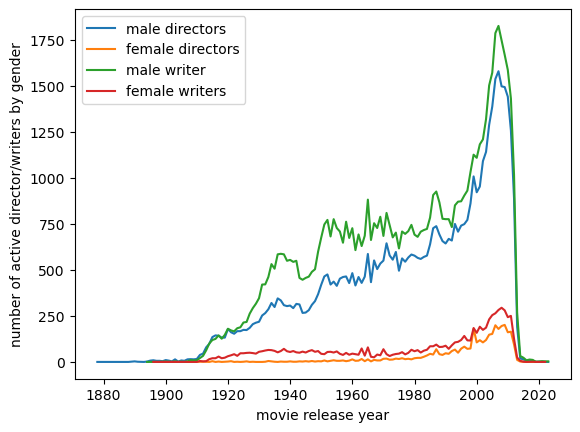

In [35]:
year_num_male_dir = directors_movies.loc[(directors_movies.role == 'director')&(directors_movies.gender == 'male')].groupby('release_year').imdb_id.nunique()
year_num_male_wri = directors_movies.loc[(directors_movies.role == 'writer')&(directors_movies.gender == 'male')].groupby('release_year').imdb_id.nunique()
year_num_female_dir = directors_movies.loc[(directors_movies.role == 'director')&(directors_movies.gender == 'female')].groupby('release_year').imdb_id.nunique()
year_num_female_wri = directors_movies.loc[(directors_movies.role == 'writer')&(directors_movies.gender == 'female')].groupby('release_year').imdb_id.nunique()

plt.plot(year_num_male_dir, label='male directors')
plt.plot(year_num_female_dir, label='female directors')
plt.plot(year_num_male_wri, label='male writer')
plt.plot(year_num_female_wri, label='female writers')
plt.legend()
plt.ylabel('number of active director/writers by gender')
plt.xlabel('movie release year')


From the above inital analysis it can be seen that the age at release and movie ratings for male and female movie directors and writes are very similar although the number of males to females in the movie industry behind the behind is siginificantly different with their being much less female directors and writers.

Next the director/writer impact metric will be added to the dataset

In [36]:
print(directors_movies.columns)

Index(['title', 'release_year', 'runtime', 'rating', 'num_votes', 'genres_cmu',
       'genres', 'movie_freebase_id', 'movie_imdb_id', 'imdb_id', 'role',
       'name', 'gender', 'birth', 'height', 'birth_year', 'age_at_release',
       'impact_score', 'genre_1', 'genre_2', 'genre_3', 'all_crew'],
      dtype='object')


In [37]:
def get_actor_metrics(metrics):
    metrics.dropna(inplace=True)

    if (metrics is None):
        return np.nan
    else:
        metrics = metrics.tolist()
        index_metrics = (list(np.argsort(metrics)))
        return np.sum([metrics[i] * 1/(len(metrics) - i) for i in index_metrics])

def get_actor_metrics_dcg(metrics):
    metrics.dropna(inplace=True)

    if (metrics is None):
        return np.nan
    else:
        # sort the metrics in descending order
        metrics = sorted(metrics, reverse=True)
        # compute the DCG score
        if len(metrics) > 0:
            dcg = metrics[0] + sum([(metrics[i] / np.log2(i+2)) for i in range(1, len(metrics))])
            return dcg
        else:
            return np.nan
# aggregate the movie metric by actor
director_metrics = directors_movies[['imdb_id', 'movie_freebase_id', 'impact_score']].drop_duplicates()[['imdb_id', 'impact_score']].groupby('imdb_id').agg(get_actor_metrics_dcg).rename(columns={'impact_score':'director_metric'})
director_metrics.head()

,director_metric
imdb_id,
\N,-269.152463
nm0000005,19.696627
nm0000008,0.870356
nm0000009,0.159650
nm0000018,-0.085042


In [38]:
directors_movies = pd.merge(directors_movies, director_metrics, left_on='imdb_id', right_index=True, how='left')
directors_movies.head()

,title,release_year,runtime,rating,num_votes,genres_cmu,genres,movie_freebase_id,movie_imdb_id,imdb_id,...,birth,height,birth_year,age_at_release,impact_score,genre_1,genre_2,genre_3,all_crew,director_metric
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[Action, Horror, Sci-Fi]",/m/03vyhn,tt0228333,nm0000118,...,1948-01-16,NaN,1948.0,53.0,2.350853,Action,Horror,Sci-Fi,False,20.870323
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",[Drama],/m/08yl5d,tt0245916,nm1740285,...,NaN,NaN,NaN,NaN,-0.357369,Drama,NaN,NaN,False,-0.357369
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","[Crime, Drama]",/m/0crgdbh,tt0094806,nm0803751,...,1945-02-17,NaN,1945.0,43.0,-0.650711,Crime,Drama,NaN,True,-1.012231
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","[Horror, Thriller]",/m/0285_cd,tt0094320,nm0131910,...,1934-01-17,NaN,1934.0,53.0,0.100801,Horror,Thriller,NaN,False,0.673164
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},[Drama],/m/01mrr1,tt0083949,nm0885554,...,1946-12-22,NaN,1946.0,37.0,-0.017109,Drama,NaN,NaN,False,-0.011414


In [39]:
temp_directors = directors_movies.copy()
temp_directors['age'] = temp_directors.birth_year.apply(lambda x: 2022 - x)
temp_directors.sort_values('director_metric', ascending=False)[['name', 'gender',  'age', 'director_metric','imdb_id']].drop_duplicates().head(50).reset_index()

,index,name,gender,age,director_metric,imdb_id
0,176076,Steven Spielberg,male,76.0,34.366147,nm0000229
1,199161,Stephen King,male,75.0,33.710949,nm0000175
2,32003,Martin Scorsese,male,80.0,31.612193,nm0000217
3,20782,Alfred Hitchcock,male,123.0,28.448965,nm0000033
4,57833,Christopher Nolan,male,52.0,28.243792,nm0634240
5,9257,Francis Ford Coppola,male,83.0,27.460857,nm0000338
6,52916,George Lucas,male,78.0,27.426989,nm0000184
7,160438,Quentin Tarantino,male,59.0,27.071797,nm0000233
8,244114,Bob Kane,male,107.0,26.888649,nm0004170
9,129455,Akira Kurosawa,male,112.0,24.592953,nm0000041



#### Director and Writer Breakdown per Movie <a id='director-writer-break'></a>

Now that trends at large have been analyzed the effect of female team members for individual movies can be looked into. 

For this analysis the data used will only include movies that have complete team member data. First does having more women on a movie's creative team lead to a higher IMDB rating?

In [40]:
rating_by_fperc = pd.DataFrame()
rating_by_fperc['percent_female'] = full_crew.groupby('movie_freebase_id').apply(
    lambda x: 100*round(len(x[x.gender == 'female'])/len(x),4))

rating_by_fperc['rating'] = full_crew.groupby('movie_freebase_id').rating.unique()
print(f'Is there only one unique rating value per movie? {all(rating_by_fperc.rating.apply(lambda x: len(x)) == 1)}')
rating_by_fperc['rating'] = rating_by_fperc['rating'].apply(lambda x: x[0])
rating_by_fperc['release_year'] = full_crew.groupby('release_year').rating.unique()
rating_by_fperc.head()

Is there only one unique rating value per movie? True


,percent_female,rating,release_year
movie_freebase_id,,,
/m/011_mj,0.0,8.1,NaN
/m/011x_4,0.0,8.1,NaN
/m/011xg5,0.0,7.2,NaN
/m/011xrr,0.0,6.2,NaN
/m/011ycb,0.0,7.5,NaN


Text(0.5, 0, 'Percentage of Females on Writing Team')

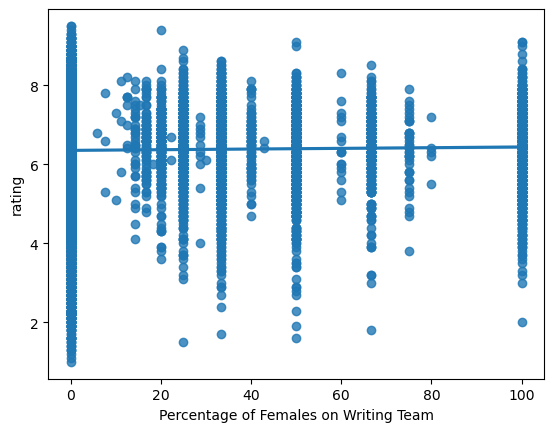

In [41]:
sns.regplot(data=rating_by_fperc, x='percent_female', y='rating')
plt.xlabel('Percentage of Females on Writing Team')

Text(0.5, 1.0, 'Average Movie Ratings Compared to Percent of Females on Creative Team')

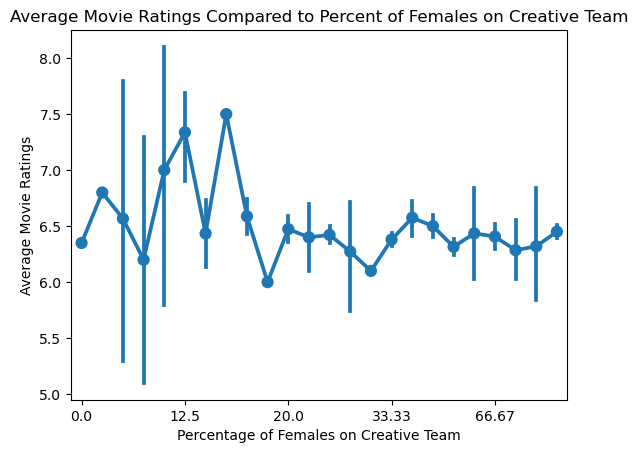

In [42]:
data_length = len(rating_by_fperc)
sns.pointplot(data=rating_by_fperc, x='percent_female', y='rating', errorbar=('ci', 95))
plt.xticks([0,5,10,15, 20])
plt.xlabel('Percentage of Females on Creative Team')
plt.ylabel('Average Movie Ratings')
plt.title('Average Movie Ratings Compared to Percent of Females on Creative Team')


In [43]:
year_by_fperc = pd.DataFrame()
year_by_fperc = pd.merge(left=rating_by_fperc, right=full_crew[['release_year', 'movie_freebase_id']], how='left', left_on=rating_by_fperc.index, right_on='movie_freebase_id' )
year_by_fperc.drop('release_year_x', inplace=True, axis=1)
year_by_fperc.rename(mapper = {'release_year_y':'release_year'}, axis=1, inplace=True)
year_by_fperc.head()

,percent_female,rating,release_year,movie_freebase_id
0,0.0,8.1,1928.0,/m/011_mj
1,0.0,8.1,1928.0,/m/011_mj
2,0.0,8.1,1993.0,/m/011x_4
3,0.0,8.1,1993.0,/m/011x_4
4,0.0,8.1,1993.0,/m/011x_4


In [44]:
year_by_fperc_avg=pd.DataFrame()
year_by_fperc_avg['percent_female_avg'] = year_by_fperc.groupby('release_year').percent_female.mean()
year_by_fperc_avg['rating_avg'] = year_by_fperc.groupby('release_year').rating.mean()
year_by_fperc_avg['number_of_titles'] = year_by_fperc.groupby('release_year').movie_freebase_id.count()
print(year_by_fperc_avg.describe())
#get rid of years that only have a few data points
old_num_titles = year_by_fperc_avg.number_of_titles.sum()
year_by_fperc_avg = year_by_fperc_avg[year_by_fperc_avg.number_of_titles>50]
new_num_titles = year_by_fperc_avg.number_of_titles.sum()

print(f'There were a total of {old_num_titles-new_num_titles} titles removed from the list')
print(f'This represented {round((old_num_titles-new_num_titles)/old_num_titles,4)*100}% of the data')


       percent_female_avg  rating_avg  number_of_titles
count          125.000000  123.000000        125.000000
mean             6.717407    6.273887        625.328000
std              4.784701    0.381390        481.127603
min              0.000000    4.500000          2.000000
25%              3.595126    6.216502        301.000000
50%              6.049573    6.387362        664.000000
75%              9.411608    6.480754        805.000000
max             33.333333    7.100000       2029.000000
There were a total of 221 titles removed from the list
This represented 0.27999999999999997% of the data


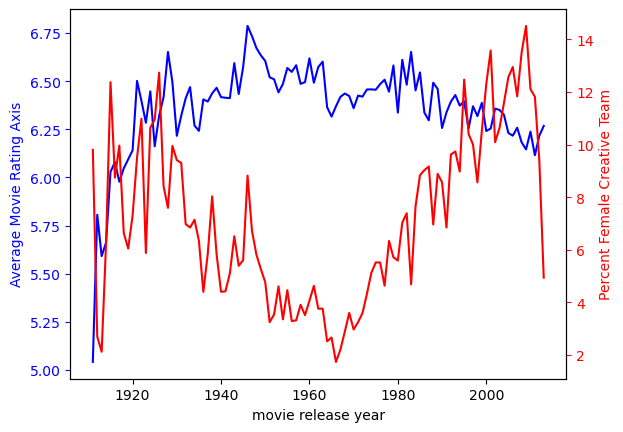

In [45]:
fig, ax = plt.subplots()

ax.plot(year_by_fperc_avg.index, year_by_fperc_avg.rating_avg, color='blue')
ax.set_ylabel('Average Movie Rating Axis', color="blue")        # set y axis title to blue
ax.tick_params(axis='y', colors="blue")       # set y axis tick labels to blue
ax.set_xlabel('movie release year')

ax2 = ax.twinx()
ax2.plot(year_by_fperc_avg.index, year_by_fperc_avg.percent_female_avg, color='red')
ax2.set_ylabel('Percent Female Creative Team', color="red")        # set y axis title to red
ax2.tick_params(axis='y', colors="red")       # set y axis tick labels to red


It can be seen that it is possible there is a inverse correlation between the average percent of women on a creative team and the average movie IMDB rating per year, but the impact does not look like its significant as the movie ratings stay within 0.5/10 from each other.


#### Genre Analysis <a id='genre'></a>

The last part of the data that will be explored is how female directors and writers are split amongst various genres of movies.

First let's understand what the most numerous genres are. The analysis will be carried out by keeping the first three genres with the assumption that the first genre present is the main genre.

In [46]:
genres_df = directors_movies.copy()
print(genres_df.columns)
print(f'There are {len(genres_df[genres_df.genres.isna()])} null values in the genres column')
print(f'There are {len(genres_df[genres_df.genres.apply(lambda x: len(x)) == 0])} empty lists in the genres column')
genres_df['genre_1'] = genres_df.genres.apply(lambda x: x[0] if len(x)>0 else np.nan)
genres_df['genre_2'] = genres_df.genres.apply(lambda x: x[1] if len(x)>1 else np.nan)
genres_df['genre_3'] = genres_df.genres.apply(lambda x: x[2] if len(x)>2 else np.nan)

genres_df.head()

Index(['title', 'release_year', 'runtime', 'rating', 'num_votes', 'genres_cmu',
       'genres', 'movie_freebase_id', 'movie_imdb_id', 'imdb_id', 'role',
       'name', 'gender', 'birth', 'height', 'birth_year', 'age_at_release',
       'impact_score', 'genre_1', 'genre_2', 'genre_3', 'all_crew',
       'director_metric'],
      dtype='object')
There are 0 null values in the genres column
There are 0 empty lists in the genres column


,title,release_year,runtime,rating,num_votes,genres_cmu,genres,movie_freebase_id,movie_imdb_id,imdb_id,...,birth,height,birth_year,age_at_release,impact_score,genre_1,genre_2,genre_3,all_crew,director_metric
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[Action, Horror, Sci-Fi]",/m/03vyhn,tt0228333,nm0000118,...,1948-01-16,NaN,1948.0,53.0,2.350853,Action,Horror,Sci-Fi,False,20.870323
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",[Drama],/m/08yl5d,tt0245916,nm1740285,...,NaN,NaN,NaN,NaN,-0.357369,Drama,NaN,NaN,False,-0.357369
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","[Crime, Drama]",/m/0crgdbh,tt0094806,nm0803751,...,1945-02-17,NaN,1945.0,43.0,-0.650711,Crime,Drama,NaN,True,-1.012231
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","[Horror, Thriller]",/m/0285_cd,tt0094320,nm0131910,...,1934-01-17,NaN,1934.0,53.0,0.100801,Horror,Thriller,NaN,False,0.673164
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},[Drama],/m/01mrr1,tt0083949,nm0885554,...,1946-12-22,NaN,1946.0,37.0,-0.017109,Drama,NaN,NaN,False,-0.011414


The first analysis to be run will be to compare the statistics of the top 15 movie genres in regards to 

In [47]:
genres_group = pd.DataFrame()
genres_group['movie_count'] = genres_df.groupby('genre_1').movie_imdb_id.agg('count')
genres_group['imdb_rating'] = genres_df.groupby('genre_1').rating.agg('mean')
genres_group['male_dirs'] = genres_df.groupby('genre_1').apply(lambda x: len(x.loc[(x.role == 'director') & (x.gender == 'male')]))
genres_group['female_dirs'] = genres_df.groupby('genre_1').apply(lambda x: len(x.loc[(x.role == 'director') & (x.gender == 'female')]))
genres_group['male_wris'] = genres_df.groupby('genre_1').apply(lambda x: len(x.loc[(x.role == 'writer') & (x.gender == 'male')]))
genres_group['female_wris'] = genres_df.groupby('genre_1').apply(lambda x: len(x.loc[(x.role == 'writer') & (x.gender == 'female')]))
genres_group['fperc_dirs'] = genres_group.female_dirs/(genres_group.female_dirs+genres_group.male_dirs)*100
genres_group['fperc_wris'] = genres_group.female_wris/(genres_group.female_wris+genres_group.male_wris)*100
genres_group.sort_values('movie_count', inplace=True, ascending=False)

top_genres = genres_group.head(15).index
genres_group.head(15)


,movie_count,imdb_rating,male_dirs,female_dirs,male_wris,female_wris,fperc_dirs,fperc_wris
genre_1,,,,,,,,
Drama,66857,6.496231,18095,1276,22908,3730,6.587166,14.002553
Comedy,62304,6.175136,16608,866,24426,2556,4.955935,9.472982
Action,34260,5.901716,8872,115,12241,537,1.279626,4.202536
Adventure,16706,6.282810,4267,110,6589,569,2.513137,7.949148
Crime,15259,6.373314,4142,160,5957,554,3.719200,8.508678
Documentary,12448,7.314195,3085,695,1792,357,18.386243,16.612378
Animation,8371,6.709217,2813,67,2584,182,2.326389,6.579899
Horror,7396,5.109901,2005,35,2581,108,1.715686,4.016363
Biography,7195,6.937889,1946,186,2239,319,8.724203,12.470680


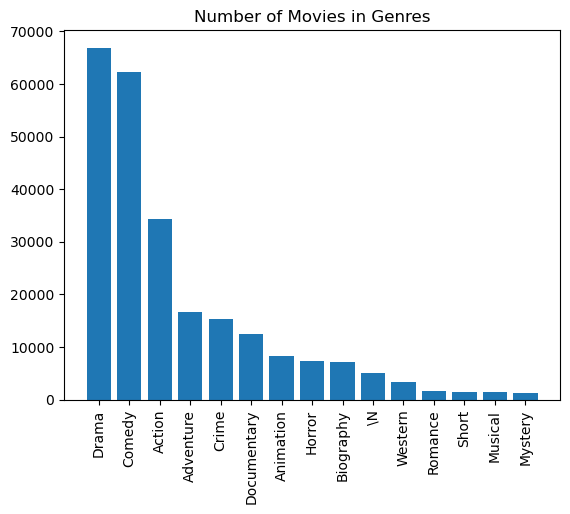

In [48]:
plt.bar(genres_group.head(15).index, genres_group.movie_count.head(15))
plt.xticks(rotation=90)
plt.title('Number of Movies in Genres')
None

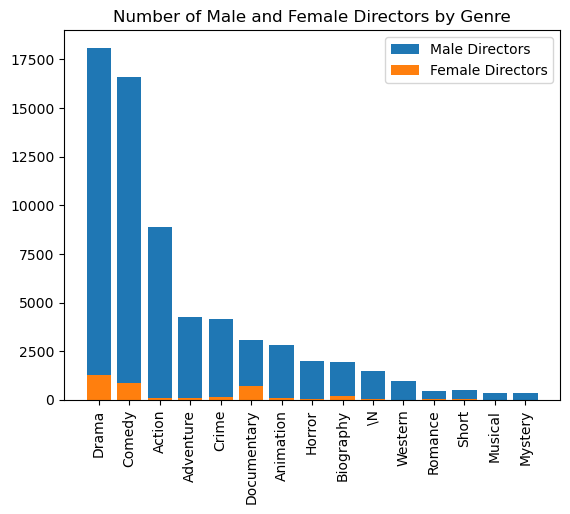

In [49]:
plt.bar(genres_group.head(15).index, genres_group.male_dirs.head(15), label='Male Directors')
plt.bar(genres_group.head(15).index, genres_group.female_dirs.head(15), label='Female Directors')
plt.xticks(rotation=90)
plt.title('Number of Male and Female Directors by Genre')
plt.legend()
None

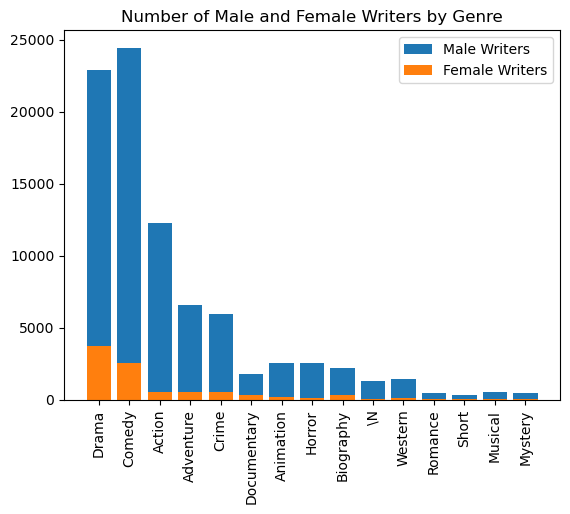

In [50]:
plt.bar(genres_group.head(15).index, genres_group.male_wris.head(15), label='Male Writers')
plt.bar(genres_group.head(15).index, genres_group.female_wris.head(15), label='Female Writers')
plt.xticks(rotation=90)
plt.title('Number of Male and Female Writers by Genre')
plt.legend()
None

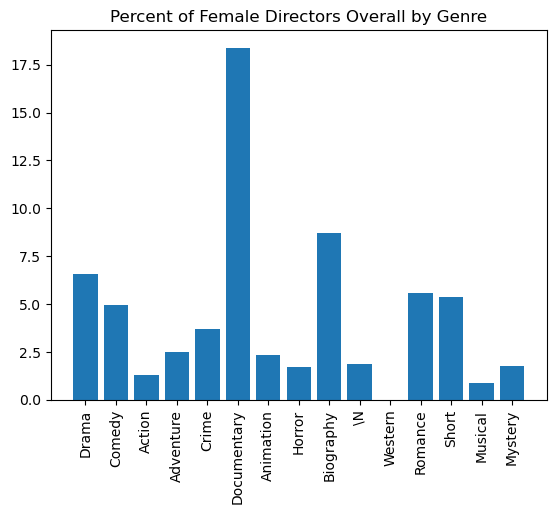

In [51]:
plt.bar(genres_group.head(15).index, genres_group.fperc_dirs.head(15))
plt.xticks(rotation=90)
plt.title('Percent of Female Directors Overall by Genre')
None

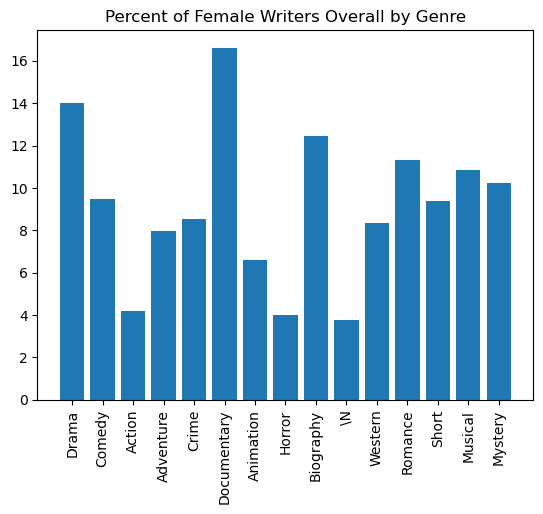

In [52]:
plt.bar(genres_group.head(15).index, genres_group.fperc_wris.head(15))
plt.xticks(rotation=90)
plt.title('Percent of Female Writers Overall by Genre')
None

It can be seen that in general there are a higher percentage of female writers in the top 15 genres than there are female directors. Next to look at is the percent of females on the creative team by genre. This will require the full_crew dataset to undergo the genre processing like the previous dataset.

In [53]:
genre_movie_groups_temp = full_crew.copy()
genre_movie_groups_temp['genre_1'] = genre_movie_groups_temp.genres.apply(lambda x: x[0] if len(x)>0 else np.nan)
genre_movie_groups_temp['genre_2'] = genre_movie_groups_temp.genres.apply(lambda x: x[1] if len(x)>1 else np.nan)
genre_movie_groups_temp['genre_3'] = genre_movie_groups_temp.genres.apply(lambda x: x[2] if len(x)>2 else np.nan)

genre_movie_groups_temp.head()


,title,release_year,runtime,rating,num_votes,genres_cmu,genres,movie_freebase_id,movie_imdb_id,imdb_id,...,gender,birth,height,birth_year,age_at_release,impact_score,genre_1,genre_2,genre_3,all_crew
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","[Crime, Drama]",/m/0crgdbh,tt0094806,nm0803751,...,male,1945-02-17,NaN,1945.0,43.0,-0.650711,Crime,Drama,NaN,True
9,City of the Dead,1960.0,76.0,6.7,7597.0,"{'/m/03npn': 'Horror', '/m/0fdjb': 'Supernatur...","[Horror, Mystery, Thriller]",/m/075f66,tt0053719,nm0610303,...,male,1925-02-26,NaN,1925.0,35.0,0.368034,Horror,Mystery,Thriller,True
12,Little city,1997.0,93.0,5.8,1111.0,"{'/m/06cvj': 'Romantic comedy', '/m/0hj3n0w': ...","[Comedy, Romance]",/m/0gffwj,tt0119548,nm0070142,...,male,1959-10-13,NaN,1959.0,38.0,0.093561,Comedy,Romance,NaN,True
21,The Devil's Holiday,1930.0,80.0,6.0,213.0,"{'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D...","[Drama, Romance]",/m/017n1b,tt0020823,nm0332539,...,male,1891-03-20,NaN,1891.0,39.0,-0.133568,Drama,Romance,NaN,True
24,Freddy and the Song of the South Pacific,1962.0,97.0,5.4,49.0,"{'/m/07s9rl0': 'Drama', '/m/03k9fj': 'Adventure'}","[Adventure, Drama]",/m/0h964n1,tt0055997,nm0414672,...,male,1909-04-24,NaN,1909.0,53.0,-0.905881,Adventure,Drama,NaN,True


In [54]:
genre_movie = pd.DataFrame()
genre_movie = pd.merge(left=year_by_fperc, right=genre_movie_groups_temp[['movie_freebase_id', 'genre_1']], 
                                how='left', on='movie_freebase_id')
genre_movie_groups = genre_movie.drop_duplicates(keep='first').groupby('genre_1')

Text(0, 0.5, 'Percent Female')

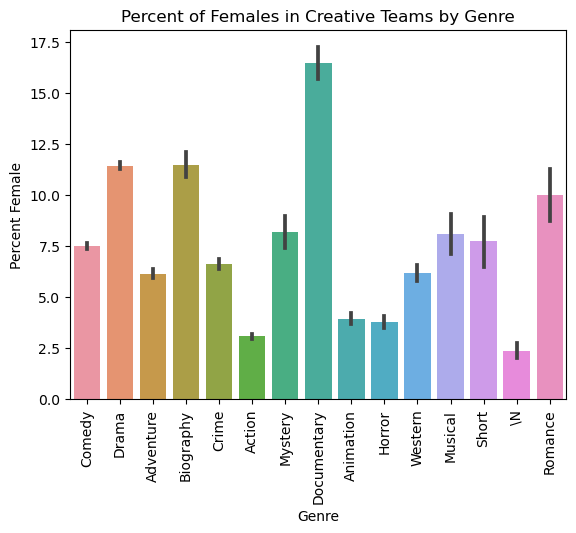

In [55]:
sns.barplot(data=genre_movie[genre_movie.genre_1.isin(top_genres)][['genre_1', 'percent_female']],
    x='genre_1', y='percent_female')
plt.xticks(rotation=90)
plt.title('Percent of Females in Creative Teams by Genre')
plt.xlabel('Genre')
plt.ylabel('Percent Female')

Text(0, 0.5, 'IMDB Rating')

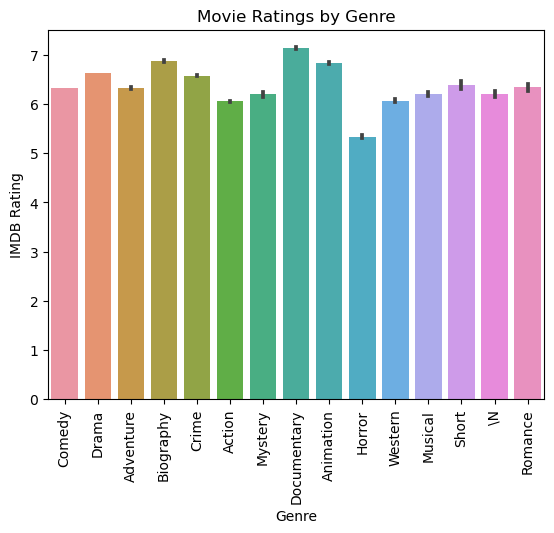

In [56]:
sns.barplot(data=genre_movie[genre_movie.genre_1.isin(top_genres)][['genre_1', 'rating']],
    x='genre_1', y='rating')
plt.xticks(rotation=90)
plt.title('Movie Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('IMDB Rating')

#### Directors and Writers in the Top 1000 Movies <a id='top-100'></a>

We have seen the trends in movies as a whole, but are there any hidden trends in the movies with the highest ratings? We can start by looking into what the top 1000 movies look like in terms of their data

In [57]:
top_movies = full_crew[['movie_freebase_id', 'rating']].groupby('movie_freebase_id').rating.agg('mean')
top_movies.sort_values(ascending=False, inplace=True)
top_movies_indx = top_movies.head(1000).index
top_movies_df = full_crew[full_crew.movie_freebase_id.isin(top_movies_indx)]
top_movies_grouped_temp = pd.DataFrame()
top_movies_grouped_temp['percent_female'] = top_movies_df.groupby('movie_freebase_id').apply(
    lambda x: 100*round(len(x[x.gender == 'female'])/len(x),4))
top_movies_grouped= pd.merge(left=top_movies_grouped_temp,
        right= top_movies_df[['movie_freebase_id', 'rating', 'runtime', 'release_year', 'genres']],
        how='left', left_index=True, right_on='movie_freebase_id')

top_movies_grouped['genre_1'] = top_movies_grouped.genres.apply(lambda x: x[0] if len(x)>1 else np.nan)

top_movies_grouped.head()


,percent_female,movie_freebase_id,rating,runtime,release_year,genres,genre_1
19434,0.0,/m/011_mj,8.1,68.0,1928.0,"[Comedy, Family, Romance]",Comedy
122442,0.0,/m/011_mj,8.1,68.0,1928.0,"[Comedy, Family, Romance]",Comedy
68686,0.0,/m/011x_4,8.1,101.0,1993.0,"[Comedy, Drama, Fantasy]",Comedy
217137,0.0,/m/011x_4,8.1,101.0,1993.0,"[Comedy, Drama, Fantasy]",Comedy
217138,0.0,/m/011x_4,8.1,101.0,1993.0,"[Comedy, Drama, Fantasy]",Comedy


Text(0.5, 1.0, 'Number of Top Movies in Genres')

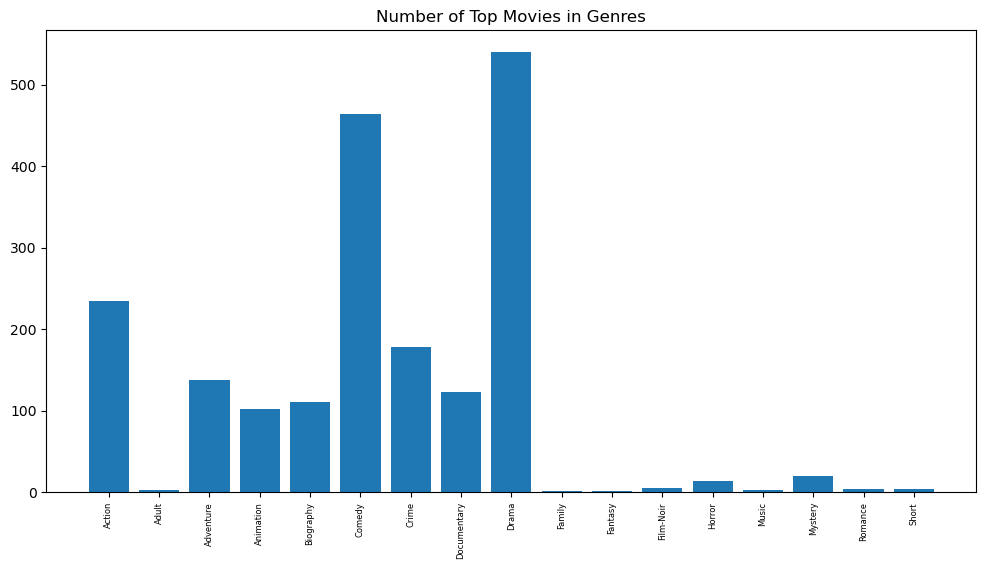

In [58]:
plt.figure(figsize=(12,6))
plt.bar(top_movies_grouped.groupby('genre_1').groups.keys(), top_movies_grouped.groupby('genre_1').movie_freebase_id.agg('count'))
plt.xticks(rotation=90, fontsize=6)
plt.title('Number of Top Movies in Genres')

Text(0.5, 1.0, 'Percent Female on the Creative Team')

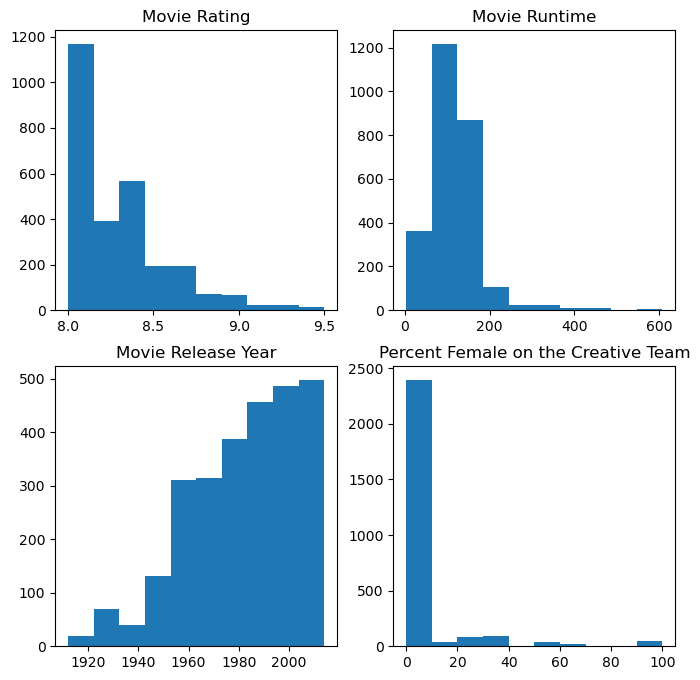

In [59]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].hist(top_movies_grouped.rating)
ax[0,0].set_title('Movie Rating')
ax[0,1].hist(top_movies_grouped.runtime)
ax[0,1].set_title('Movie Runtime')
ax[1,0].hist(top_movies_grouped.release_year)
ax[1,0].set_title('Movie Release Year')
ax[1,1].hist(top_movies_grouped.percent_female)
ax[1,1].set_title('Percent Female on the Creative Team')

Now we can look at at the make up of directors and writers in these top 1000 movies in terms of gender.

In [60]:
male_dir_top = top_movies_df.loc[(top_movies_df.gender == 'male') & (top_movies_df.role == 'director')]
female_dir_top = top_movies_df.loc[(top_movies_df.gender == 'female') & (top_movies_df.role == 'director')]
male_wri_top = top_movies_df.loc[(top_movies_df.gender == 'male') & (top_movies_df.role == 'writer')]
female_wri_top = top_movies_df.loc[(top_movies_df.gender == 'female') & (top_movies_df.role == 'writer')]

print(f'Out of the top 1000 Movies there are {len(male_dir_top)} male directors and {len(female_dir_top)} female directors.')
print(f'{male_dir_top.imdb_id.nunique()} of those male directors are unique and {female_dir_top.imdb_id.nunique()} of those female directors are unique.')
print()
print(f'Out of the top 1000 Movies there are {len(male_wri_top)} male writers and {len(female_wri_top)} female writers.')
print(f'{male_wri_top.imdb_id.nunique()} of those male writers are unique and {female_wri_top.imdb_id.nunique()} of those female writers are unique.')

Out of the top 1000 Movies there are 1032 male directors and 40 female directors.
745 of those male directors are unique and 38 of those female directors are unique.

Out of the top 1000 Movies there are 1548 male writers and 92 female writers.
1114 of those male writers are unique and 83 of those female writers are unique.


### Analysis after Milestone 2 <a id='M2'></a>

#### New Metric for Movie Ratings <a id='new-metric'></a>

Now that we have decided a new metric for to measure the data we can create that for our datasheet and then rerun the analysis

First a review of the Dataframes that we may want to use again

director_movies - Base dataframe with all merged data <br>
dirs – all directors values <br>
writers – all writers values<br>
uniq_dirs – all uniq director values<br>
uniq_wris – all unique writer values<br>
full_dirs – unique directors with gender, name, and birth data<br>
full_wris – unique writers with gender, name, and birth data<br>
full_crew – movies that have director and writer data that all has at least a male or female gender<br>
male_dir – male directors<br>
male_writer – male writers<br>
female_dir – female directors<br>
female_writer – female writers<br>
rating_by_fperc – dataframe with each movie ID containing info of percent_female and rating, <br>
year_by_fperc – dataframe with each movie ID containing info of percent female and release year<br>
year_by_fperc_avg – Dataframe with year_by_fperc data but averaged over each release year<br>
genres_df – this dataframe is a copy of the directors_movies dataframe, but the genres are now divided up as genre_1, genre_2, and genre_3<br>
genres_group – dataframe with the data from genres_df but grouped by genre_1


The first goal will be to determine the impact of movies based on the female crew percent for this we can create a dataframe with the impact score by fpercent

In [61]:
directors_movies.impact_score.describe()

count    234845.000000
mean          0.021948
std           1.018067
min          -8.500313
25%          -0.347265
50%          -0.007057
75%           0.329393
max           9.473819
Name: impact_score, dtype: float64

In [62]:
impact_score_by_fperc = pd.DataFrame()
impact_score_by_fperc['percent_female'] = full_crew.groupby('movie_freebase_id').apply(
    lambda x: 100*round(len(x[x.gender == 'female'])/len(x),4))

impact_score_by_fperc['impact_score'] = full_crew.groupby('movie_freebase_id').impact_score.unique()
print(f'Is there only one unique impact_score value per movie? {all(impact_score_by_fperc.impact_score.apply(lambda x: len(x)) == 1)}')
impact_score_by_fperc['impact_score'] = impact_score_by_fperc['impact_score'].apply(lambda x: x[0])
impact_score_by_fperc['release_year'] = full_crew.groupby('movie_freebase_id').release_year.unique()
print(f'Is there only one unique release_year value per movie? {all(impact_score_by_fperc.release_year.apply(lambda x: len(x)) == 1)}')
impact_score_by_fperc['release_year'] = impact_score_by_fperc['release_year'].apply(lambda x: x[0])
impact_score_by_fperc.head()

Is there only one unique impact_score value per movie? True
Is there only one unique release_year value per movie? True


,percent_female,impact_score,release_year
movie_freebase_id,,,
/m/011_mj,0.0,2.686725,1928.0
/m/011x_4,0.0,4.692854,1993.0
/m/011xg5,0.0,2.100958,2001.0
/m/011xrr,0.0,0.141074,1984.0
/m/011ycb,0.0,2.122550,1994.0


Text(0.5, 0, 'Percentage of Females on Writing Team')

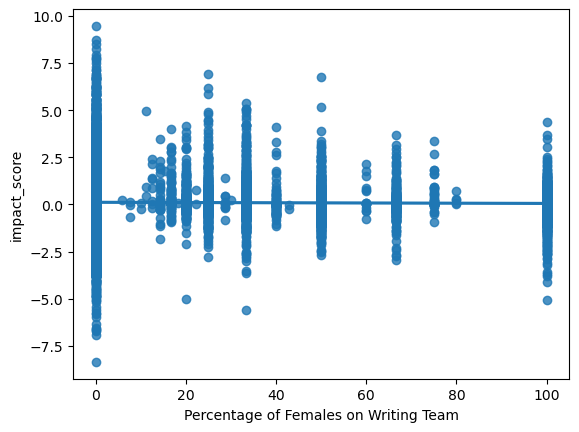

In [63]:
sns.regplot(data=impact_score_by_fperc, x='percent_female', y='impact_score')
plt.xlabel('Percentage of Females on Writing Team')

Text(0.5, 1.0, 'Average Movie impact_scores Compared to Percent of Females on Creative Team')

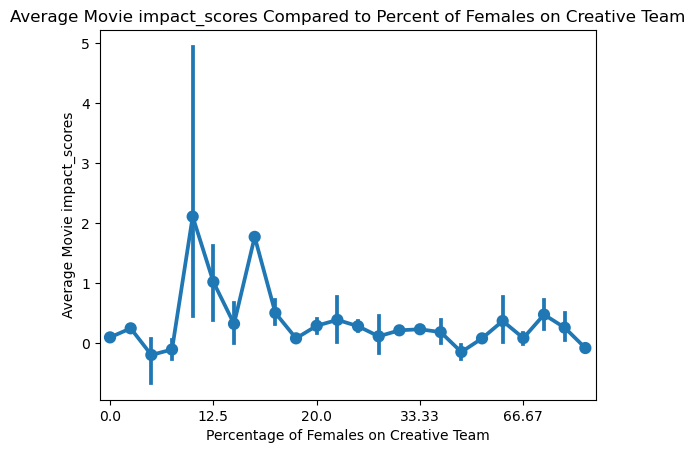

In [64]:
sns.pointplot(data=impact_score_by_fperc, x='percent_female', y='impact_score', errorbar=('ci', 95))
plt.xticks([0,5,10,15, 20])
plt.xlabel('Percentage of Females on Creative Team')
plt.ylabel('Average Movie impact_scores')
plt.title('Average Movie impact_scores Compared to Percent of Females on Creative Team')


We can try creating two linear regression models, the first can be based off of a movie and information surrounding the director and average crew data, the other one could be linked to the people themselves.

In [65]:
print(full_crew.columns)

Index(['title', 'release_year', 'runtime', 'rating', 'num_votes', 'genres_cmu',
       'genres', 'movie_freebase_id', 'movie_imdb_id', 'imdb_id', 'role',
       'name', 'gender', 'birth', 'height', 'birth_year', 'age_at_release',
       'impact_score', 'genre_1', 'genre_2', 'genre_3', 'all_crew'],
      dtype='object')


#### Matching <a id='match'></a>

matching was attempted on the dataset to further analyze the data, but the amount of datapoints was too great to do matching with networkx and the kernel would crash before finishing. Due to time constraints the matching analysis was dropped from the project. The code below is commented out so that it doesn't run when the notebook is run

In [66]:
# movie_reg = pd.DataFrame()
# full_crew_grouped = full_crew.groupby('movie_freebase_id')
# director_grouped = full_crew.loc[full_crew.role == 'director'].groupby('movie_freebase_id')
# writer_grouped = full_crew.loc[full_crew.role == 'writer'].groupby('movie_freebase_id')
# movie_reg['impact_score'] = full_crew_grouped.impact_score.unique()
# if all(movie_reg.impact_score.apply(lambda x: len(x)) == 1):
#     movie_reg['impact_score'] = movie_reg.impact_score.apply(lambda x: x[0])
# movie_reg['director_fperc'] = director_grouped.apply(
#     lambda x: round(len(x[x.gender == 'female'])/len(x),4)) #This is because there are movies with several directors
# movie_reg['writer_fperc'] = writer_grouped.apply(
#     lambda x: round(len(x[x.gender == 'female'])/len(x),4)) #This is because there are movies with several directors
# movie_reg['director_male'] = movie_reg.director_fperc.apply(lambda x: 1 if x==0 else 0)
# movie_reg['director_female'] = movie_reg.director_fperc.apply(lambda x: 1 if x==1 else 0)
# movie_reg['full_male'] = movie_reg.apply(lambda x: 1 if x.director_fperc == 0 and x.writer_fperc == 0 else 0, axis=1)
# movie_reg['full_female'] = movie_reg.apply(lambda x: 1 if x.director_fperc == 1 and x.writer_fperc == 1 else 0, axis=1)
# print(f'The length of the original dataset is {len(directors_movies)}, the full crew length is {len(full_crew)}, the length of the final dataset is {len(movie_reg)}')

# movie_reg

In [67]:
# def split_set(data_to_split, ratio=0.8):
#     mask = np.random.rand(len(data_to_split)) < ratio
#     return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [68]:
# train, test = split_set(movie_reg.dropna())

# train_features = train[['director_fperc', 'writer_fperc', 'director_male', 'director_female', 'full_male', 'full_female']]
# train_y = train['impact_score']
# test_features = train[['director_fperc', 'writer_fperc', 'director_male', 'director_female', 'full_male', 'full_female']]
# test_y = train['impact_score']
# from sklearn.linear_model import LinearRegression

# model = LinearRegression()
# model.fit(train_features,train_y)

In [69]:
# print(model.intercept_, model.coef_, model.score(train_features, train_y))

In [70]:
# import statsmodels.api as sm

# x = sm.add_constant(train_features)
# model_2 = sm.OLS(train_y, x).fit()

# print(model_2.summary())

so it looks like regardless of what we do it isn't giving us a model that can fit the data. Let's take a look at genres instead for now. the first thing to do would be to either look at the best genres or the most abundant genres, I think we can look at abundance first

In [71]:
# genre_amounts = full_crew.groupby('genre_1').genre_1.apply('count')
# genres_considered = genre_amounts.sort_values(ascending=False).head(50).index.tolist()
# genres_considered


In [72]:
# R2 = []

# for genre in genres_considered:
#     genre_df = full_crew.loc[full_crew.genre_1 == genre].drop(['normal_rating', 'abs_normal_rating',
#         'log_num_votes', 'normal_log_num_votes', 'impact_score', 'impact_score_2'], axis=1
#     )
#     mean_ratings = genre_df.rating.mean()
#     std_ratings = genre_df.rating.std()
#     genre_df['normal_rating'] = (genre_df.rating-mean_ratings)/std_ratings
#     genre_df['abs_normal_rating'] = abs(genre_df.normal_rating)

#     genre_df['log_num_votes'] = np.log(genre_df.num_votes)
#     mean_log_votes = genre_df.log_num_votes.mean()
#     std_log_votes = genre_df.log_num_votes.std()
#     genre_df['normal_log_num_votes'] = (genre_df.log_num_votes - mean_log_votes)/std_log_votes
#     min_norm_log_num_votes = genre_df.normal_log_num_votes.min()

#     genre_df['impact_score'] = (genre_df.normal_log_num_votes) * genre_df.abs_normal_rating

#     df = pd.DataFrame()
#     genre_df_grouped = genre_df.groupby('movie_freebase_id')
#     director_grouped = genre_df.loc[genre_df.role == 'director'].groupby('movie_freebase_id')
#     writer_grouped = genre_df.loc[genre_df.role == 'writer'].groupby('movie_freebase_id')

#     df['impact_score'] = genre_df_grouped.impact_score.unique()
#     if all(df.impact_score.apply(lambda x: len(x)) == 1):
#         df['impact_score'] = df.impact_score.apply(lambda x: x[0])
#     df['director_fperc'] = director_grouped.apply(
#         lambda x: round(len(x[x.gender == 'female'])/len(x),4)) #This is because there are movies with several directors
#     df['writer_fperc'] = writer_grouped.apply(
#         lambda x: round(len(x[x.gender == 'female'])/len(x),4)) #This is because there are movies with several directors
#     df['director_male'] = df.director_fperc.apply(lambda x: 1 if x==0 else 0)
#     df['director_female'] = df.director_fperc.apply(lambda x: 1 if x==1 else 0)
#     df['full_male'] = df.apply(lambda x: 1 if x.director_fperc == 0 and x.writer_fperc == 0 else 0, axis=1)
#     df['full_female'] = df.apply(lambda x: 1 if x.director_fperc == 1 and x.writer_fperc == 1 else 0, axis=1)
#     df.dropna(inplace=True)

#     features = df[['director_fperc', 'writer_fperc', 'director_male', 'director_female', 'full_male', 'full_female']]
#     y = df['impact_score']

#     x = sm.add_constant(features)
#     model_2 = sm.OLS(y, x).fit()
#     print(genre)
#     print(model_2.summary())
#     print()
#     row={
#         'genre':genre,
#         'r2':model_2.rsquared,
#         'movies':len(df)
#     }
#     R2.append(row)
    
    
# genre_regg = pd.DataFrame(R2)
# genre_regg.sort_values('r2', ascending=False)

In [73]:
# print(directors_movies.columns)
# matching_df = directors_movies[[
#     'release_year',
#     'rating',
#     'num_votes',
#     'movie_freebase_id',
#     'role',
#     'gender',
#     'age_at_release',
#     'genre_1'
# ]].copy()

# print(len(matching_df))
# print(len(matching_df.dropna()))
# matching_df.head()

In [74]:
# genre_amounts = full_crew.groupby('genre_1').genre_1.apply('count')
# genres_considered = genre_amounts.sort_values(ascending=False).head(1).index.tolist()
# genres_considered

In [75]:
# matching_df_drop = matching_df.loc[matching_df.genre_1.isin(genres_considered)].dropna().copy()
# matching_df_drop['normalized_log_votes'] = (np.log(matching_df_drop.num_votes)-np.log(matching_df_drop.num_votes).mean())/np.log(matching_df_drop.num_votes).std()
# matching_df_drop['normalized_rating'] = (matching_df_drop.rating - matching_df_drop.rating.mean())/matching_df_drop.rating.std()
# matching_df_drop['impact_score'] = matching_df_drop.normalized_log_votes *abs(matching_df_drop.normalized_rating)

# categorical_columns = ['role', 'gender']#, 'genre_1']

# train_categorical = pd.get_dummies(matching_df_drop,columns=categorical_columns)
# print(train_categorical.columns)
# train_label = train_categorical.gender_female
# train_features = train_categorical.drop(['gender_male','gender_female','normalized_log_votes','normalized_rating','release_year', 'movie_freebase_id', 'genre_1'], axis=1)

# means = train_features.mean()
# stddevs = train_features.std()

# train_features_std = pd.DataFrame()
# for c in train_features.columns:
#     train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# train_features_std


In [76]:
# import networkx as nx
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from sklearn.linear_model import LogisticRegression

# logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
# logistic.fit(train_features_std, train_label)

# propensity_scores = logistic.predict_proba(train_features_std)
# matching_df_drop['propensity_score'] = propensity_scores[:,1]
# matching_df_drop.head()

In [77]:
# treatment_df = matching_df_drop.loc[matching_df_drop.gender == 'female']
# control_df = matching_df_drop.loc[matching_df_drop.gender == 'male']

# def get_similarity(propensity_score1, propensity_score2):
#     '''Calculate similarity for instances with given propensity scores'''
#     return 1-np.abs(propensity_score1-propensity_score2)

# G = nx.Graph()

# # Loop through all the pairs of instances
# for control_id, control_row in control_df.iterrows():
#     for treatment_id, treatment_row in treatment_df.iterrows():

#         # Calculate the similarity 
#         similarity = get_similarity(control_row['propensity_score'],
#                                     treatment_row['propensity_score'])

#         # Add an edge between the two instances weighted by the similarity between them
#         G.add_weighted_edges_from([(control_id, treatment_id, similarity)])



In [78]:
# matching = nx.max_weight_matching(G)
# matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
# balanced_df_all = matching_df_drop.iloc[matched]

# balanced_df_all.to_pickle('./temp_pickle_matching.p')

### Data Visualization for Data Story <a id='data-story'></a>

the following code contains the dataframes and graphs required for the final datastory

In [79]:
# uncomment to install plotly
# %pip install dash   
# %pip install dash-html-components                                         
# %pip install dash-core-components                                     
# %pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [88]:
import dash   
import dash_core_components as dcc  
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

#### Graph 1 <a id='graph1'></a>

The first graph to create will use the entire director dataset after dropping the NaN values

In [81]:
print(directors_movies.columns)

Index(['title', 'release_year', 'runtime', 'rating', 'num_votes', 'genres_cmu',
       'genres', 'movie_freebase_id', 'movie_imdb_id', 'imdb_id', 'role',
       'name', 'gender', 'birth', 'height', 'birth_year', 'age_at_release',
       'impact_score', 'genre_1', 'genre_2', 'genre_3', 'all_crew',
       'director_metric'],
      dtype='object')


In [104]:
graph_1_df = directors_movies[[
    'release_year',
    'gender',
]].dropna().copy()
graph_1_df.head()

,release_year,gender
0,2001.0,male
2,1988.0,male
3,1987.0,male
4,1983.0,male
6,2002.0,male


In [105]:
from math import floor
graph_1_df['decade'] = graph_1_df.release_year.apply(lambda x: int(floor(x/10)*10))
graph_1_df = graph_1_df.loc[(graph_1_df.decade<=2010) & (graph_1_df.decade >= 1930)]
graph_1_df.describe()

,release_year,decade
count,155573.000000,155573.000000
mean,1978.102608,1973.642084
std,24.983739,25.006139
min,1930.000000,1930.000000
25%,1956.000000,1950.000000
50%,1982.000000,1980.000000
75%,2002.000000,2000.000000
max,2019.000000,2010.000000


In [115]:
graph_1_df_male = pd.DataFrame()
graph_1_df_female = pd.DataFrame()
graph_1_df_male['count'] = graph_1_df.loc[graph_1_df.gender == 'male'].groupby('decade').apply(lambda x: x.gender.count())
graph_1_df_male['decade'] = graph_1_df.loc[graph_1_df.gender == 'male'].groupby('decade').apply(lambda x: (x.decade.unique())[0])
graph_1_df_male['gender'] = 'male'
graph_1_df_female['count'] = graph_1_df.loc[graph_1_df.gender == 'female'].groupby('decade').apply(lambda x: x.gender.count())
graph_1_df_female['decade'] = graph_1_df.loc[graph_1_df.gender == 'female'].groupby('decade').apply(lambda x: (x.decade.unique())[0])
graph_1_df_female['gender'] = 'female'

graph_1_df_final = pd.concat([graph_1_df_male,graph_1_df_female])
graph_1_df_final.reset_index(drop=True, inplace=True)

graph_1_df_final.head()

,count,decade,gender
0,13408,1930,male
1,11939,1940,male
2,15785,1950,male
3,14602,1960,male
4,14537,1970,male


In [118]:
fig = px.bar(graph_1_df_final, x="decade", y="count",
             color='gender', barmode='group',
             height=400)
fig.show()

#### Graph 2 <a id='graph2'></a>

The second graph will use only the data that has the full crew associated with it. This is so that the female percent can be calculated more accurately

In [123]:
graph_2_df = full_crew.copy()
graph_2_df['decade'] = graph_2_df.release_year.apply(lambda x: int(floor(x/10)*10))
graph_2_df = graph_2_df.loc[(graph_2_df.decade<=2010) & (graph_2_df.decade >= 1930)]

In [124]:
decade_by_fperc = pd.DataFrame()
movie_by_fperc = pd.DataFrame()
movie_by_fperc['percent_female'] = graph_2_df.groupby('movie_freebase_id').apply(
    lambda x: 100*round(len(x[x.gender == 'female'])/len(x),4))

movie_by_fperc['decade'] = graph_2_df.groupby('movie_freebase_id').decade.unique()
print(f'Is there only one unique decade value per movie? {all(movie_by_fperc.decade.apply(lambda x: len(x)) == 1)}')
movie_by_fperc['decade'] = movie_by_fperc['decade'].apply(lambda x: x[0])
decade_by_fperc['percent_female'] = movie_by_fperc.groupby('decade').apply(
    lambda x: x.percent_female.mean()
)
decade_by_fperc['decade'] = movie_by_fperc.groupby('decade').apply(lambda x: (x.decade.unique())[0])
decade_by_fperc.head()

Is there only one unique decade value per movie? True


,percent_female,decade
decade,,
1930,5.701144,1930
1940,4.954606,1940
1950,3.318016,1950
1960,3.028668,1960
1970,4.502299,1970


In [125]:
fig = px.bar(decade_by_fperc, x='decade', y='percent_female')
fig.show()

#### Graph 3 <a id='graph2'></a>

The third graph like the second will use the full_crew data set

In [127]:
graph_3_df = full_crew.copy()
graph_3_df['decade'] = graph_3_df.release_year.apply(lambda x: int(floor(x/10)*10))
graph_3_df = graph_3_df.loc[(graph_3_df.decade<=2010) & (graph_3_df.decade >= 1930)]

We will need to have each genre have its own row. For this graph we will need the female percent, genre, and decade so we will only take those columns from the first dataframe

In [128]:
print(graph_3_df.columns)

Index(['title', 'release_year', 'runtime', 'rating', 'num_votes', 'genres_cmu',
       'genres', 'movie_freebase_id', 'movie_imdb_id', 'imdb_id', 'role',
       'name', 'gender', 'birth', 'height', 'birth_year', 'age_at_release',
       'impact_score', 'genre_1', 'genre_2', 'genre_3', 'all_crew', 'decade'],
      dtype='object')


In [150]:
graph_3_df_1 = pd.concat([
    graph_3_df[['release_year', 'movie_freebase_id', 'gender', 'decade', 'genre_1']].dropna().rename(mapper={'genre_1':'genre'}, axis=1),
    graph_3_df[['release_year', 'movie_freebase_id', 'gender', 'decade', 'genre_2']].dropna().rename(mapper={'genre_2':'genre'}, axis=1),
    graph_3_df[['release_year', 'movie_freebase_id', 'gender', 'decade', 'genre_3']].dropna().rename(mapper={'genre_3':'genre'}, axis=1)
])

graph_3_df_1 = graph_3_df_1.loc[graph_3_df_1.genre != r'\N']
graph_3_df_1.reset_index(inplace=True, drop=True)
graph_3_df_1.head()

,release_year,movie_freebase_id,gender,decade,genre
0,1988.0,/m/0crgdbh,male,1980.0,Crime
1,1960.0,/m/075f66,male,1960.0,Horror
2,1997.0,/m/0gffwj,male,1990.0,Comedy
3,1930.0,/m/017n1b,male,1930.0,Drama
4,1962.0,/m/0h964n1,male,1960.0,Adventure


In [155]:
graph_3_df_2 = pd.DataFrame()
graph_3_df_final = pd.DataFrame()
graph_3_df_2['percent_female'] = graph_3_df_1.groupby('movie_freebase_id').apply(
    lambda x: 100*round(len(x[x.gender == 'female'])/len(x),4))

graph_3_df_2['decade'] = graph_3_df_1.groupby('movie_freebase_id').decade.unique()
print(f'Is there only one unique decade value per movie? {all(graph_3_df_2.decade.apply(lambda x: len(x)) == 1)}')
graph_3_df_2['decade'] = graph_3_df_2['decade'].apply(lambda x: x[0])

graph_3_df_2['genre'] = graph_3_df_1.groupby('movie_freebase_id').genre.unique()
print(f'Is there only one unique genre value per movie? {all(graph_3_df_2.genre.apply(lambda x: len(x)) == 1)}')
graph_3_df_2['genre'] = graph_3_df_2['genre'].apply(lambda x: x[0])

graph_3_df_final['percent_female'] = graph_3_df_2.groupby(['genre', 'decade']).agg('mean')

graph_3_df_final = graph_3_df_final.reset_index()

graph_3_df_final.head()

Is there only one unique decade value per movie? True
Is there only one unique genre value per movie? False


,genre,decade,percent_female
0,Action,1930.0,4.313765
1,Action,1940.0,4.247805
2,Action,1950.0,1.190504
3,Action,1960.0,0.938931
4,Action,1970.0,2.111262


In [181]:
import plotly.graph_objects as go

# set up multiple traces
traces = []
buttons = []
for genre in graph_3_df_final.genre.unique():
    traces.append(go.Scatter(x=graph_3_df_final.loc[graph_3_df_final['genre'] == genre].decade,
                            y=graph_3_df_final.loc[graph_3_df_final['genre'] == genre].percent_female,
                            visible=True,
                            name=genre)
                )
    buttons.append(dict(method='restyle',
                        label=genre,
                        visible=True,
                        args=[{'visible':True},[i for i,x in enumerate(traces) if x.name == genre]],
                        args2=[{'visible':'legendonly'},[i for i,x in enumerate(traces) if x.name == genre]]
                        ))

# create the layout 
layout = go.Layout(
    updatemenus=[
        dict(
            type='buttons',
            direction='down',
            x=0.7,
            y=1.3,
            showactive=True,
            buttons=buttons
        )
    ],
    title=dict(text='Toggle Traces',x=0.5),
    showlegend=True
)

fig = go.Figure(data=traces,layout=layout)

# add dropdown menus to the figure

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="LightSteelBlue",
)
fig.show()